In [ ]:
# Install necessary packages
!pip install opencv-python opencv-python-headless pytesseract pillow

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from pytesseract import Output
import pytesseract

In [21]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

Saving input_image.png to input_image.png


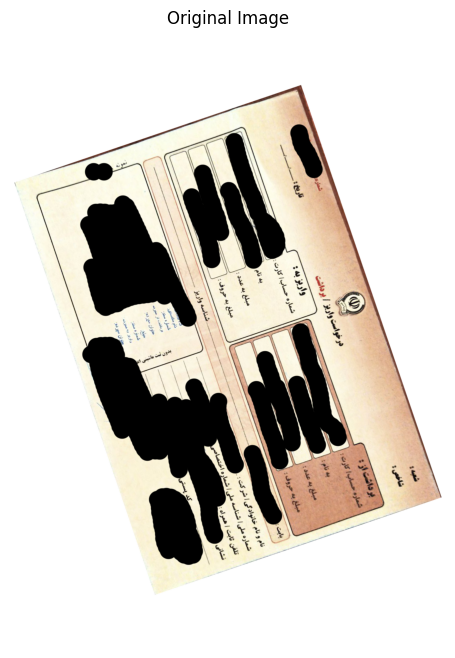

In [22]:
# Function to display images
def display_image(title, img, cmap=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Display original image
display_image("Original Image", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


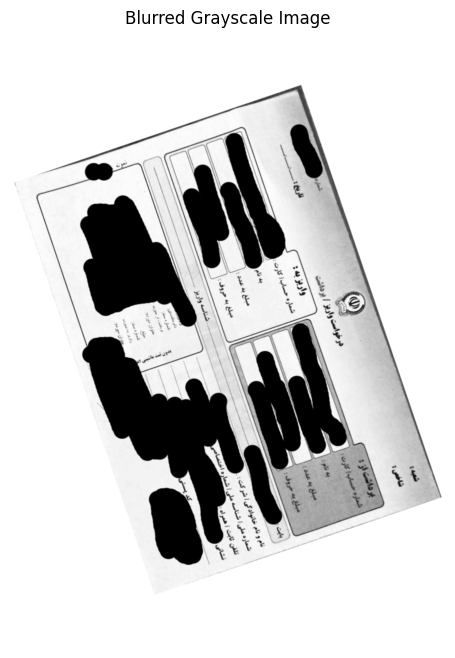

In [23]:
# Convert to grayscale and apply Gaussian blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
display_image("Blurred Grayscale Image", blurred, cmap='gray')

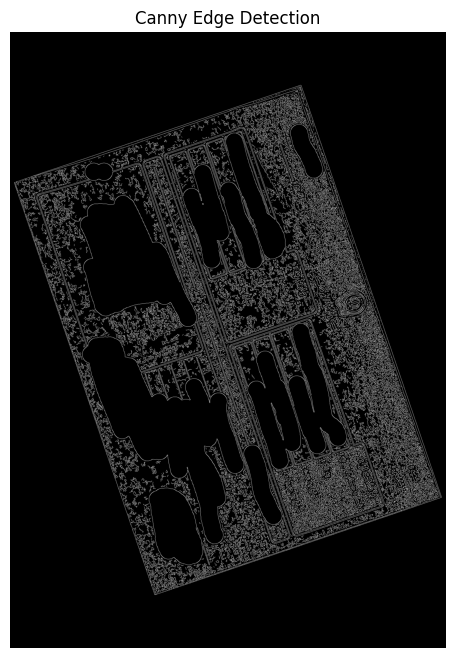

In [24]:
# Edge detection
edges = cv2.Canny(blurred, 1, 10)
display_image("Canny Edge Detection", edges, cmap='gray')

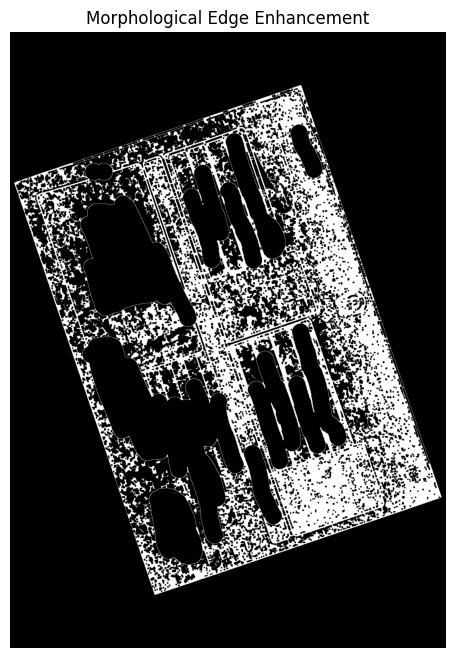

In [25]:
# Morphological operations
kernel = np.ones((5, 5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
edges = cv2.erode(edges, kernel, iterations=1)
display_image("Morphological Edge Enhancement", edges, cmap='gray')

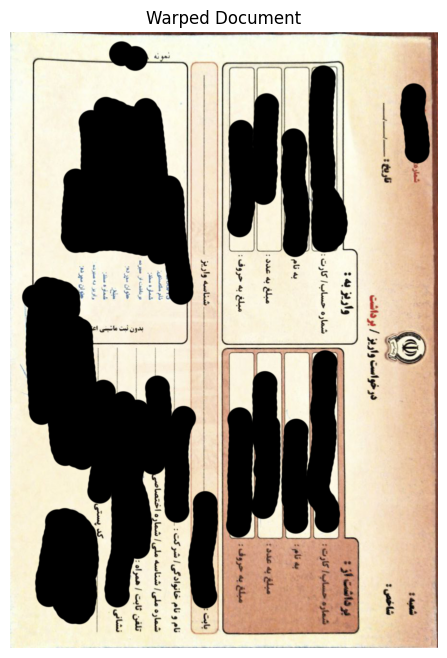

In [26]:
# Find and sort contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

# Detect document contour
document_contour = None
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        document_contour = approx
        break

# Perspective transformation if document contour is found
Warped_Document = False
if document_contour is not None:
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    points = document_contour.reshape(4, 2)
    ordered_pts = order_points(points)
    (tl, tr, br, bl) = ordered_pts
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered_pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    Warped_Document = True
    # Display warped document
    display_image("Warped Document", cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
else:
    print("Document contour could not be found.")

In [27]:
# Install and configure Tesseract for Persian OCR
!sudo apt-get install tesseract-ocr tesseract-ocr-fas -y
!wget https://github.com/tesseract-ocr/tessdata/raw/main/fas.traineddata
!mv fas.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-fas is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-11-09 11:55:58--  https://github.com/tesseract-ocr/tessdata/raw/main/fas.traineddata
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/fas.traineddata [following]
--2024-11-09 11:55:58--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/fas.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reque

Detected best angle: 90


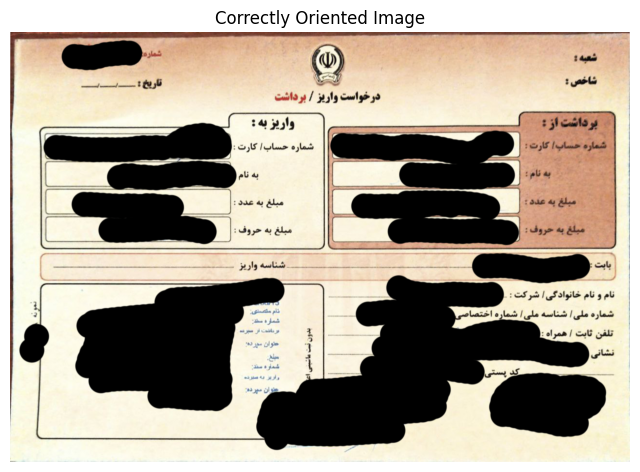

In [28]:
# OCR functions
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    return cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def ocr_image(image, lang='fas'):
    config = r'--oem 3 --psm 6 -l ' + lang
    details = pytesseract.image_to_data(image, output_type=Output.DICT, config=config)
    return details

def get_orientation(image):
    angles = [0, 90, 180, 270]
    ocr_results = []
    h, w = image.shape[:2]
    crop_img = image[h//4:h*3//4, w//4:w*3//4]
    for angle in angles:
        rotated_crop = rotate_image(crop_img, angle)
        details = ocr_image(rotated_crop, lang='fas')
        num_chars = sum(len(word) for word in details['text'] if isinstance(word, str))
        ocr_results.append((angle, num_chars))
    return max(ocr_results, key=lambda x: x[1])[0]

# Determine the best orientation angle
if Warped_Document:
    img_for_ocr = warped
else:
    img_for_ocr = image

correct_angle = get_orientation(img_for_ocr)
print(f"Detected best angle: {correct_angle}")


# Rotate to correct orientation and display
rotated_image = rotate_image(img_for_ocr, correct_angle)
display_image("Correctly Oriented Image", cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))